# Flight Stationarity

In this notebook we will check the stationarity of variables in the flight telemetry. Stationarity tests will be performed and removal techniques will be used.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We first import the flight telemetry data in pandas

In [2]:
df = pd.read_csv("data/666200402020631.csv")
df = df.drop(columns=[df.columns[0]])
df.head()

,VAR_2670,VAR_5107,VAR_6670,FPAC,BLAC,CTAC,TH,MH,EGT_1,EGT_2,...,ATEN,LATP,FIRE_1,FIRE_2,FIRE_3,FIRE_4,FGC3,ILSF,ESN_1,ESN_2
0,1465.0,2632.0,3513.0,0.000006,0.001960,-0.000023,-28.488613,-24.507687,79.034841,78.934205,...,-5.199093e-17,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
1,1465.0,2632.0,3513.0,-0.000007,0.002785,0.000023,-49.740381,-42.089356,6.751757,6.722887,...,-2.599547e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
2,1465.0,2632.0,3513.0,0.000007,0.003202,-0.000023,-43.547730,-37.325465,27.224032,27.257060,...,-1.733031e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
3,1465.0,2632.0,3513.0,-0.000007,0.002608,0.000023,-47.318559,-40.029642,15.059799,15.043408,...,-1.386425e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
4,1465.0,2632.0,3513.0,0.000007,0.003288,-0.000023,-44.565684,-38.190090,23.850340,23.755760,...,-1.391841e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0


We plot the first 4 variables in the database

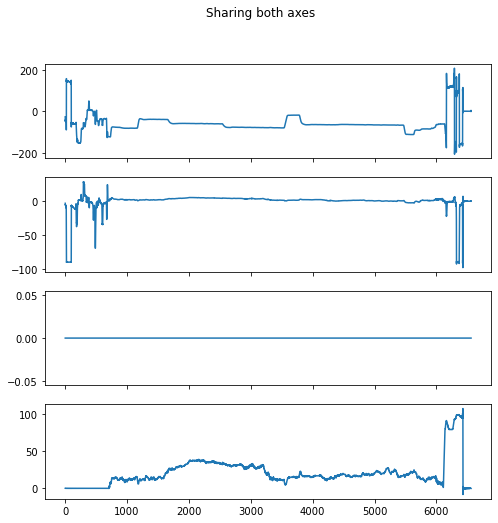

In [3]:
fig, axs = plt.subplots(4, sharex=True, figsize=(8,8))
fig.suptitle('Sharing both axes')
i=15
axs[0].plot(df.index, df.iloc[:,i])
axs[1].plot(df.index, df.iloc[:,i+1])
axs[2].plot(df.index, df.iloc[:,i+2])
axs[3].plot(df.index, df.iloc[:,i+3])

We now proceed with a test to check if data is stationary called Augmented Dickey-Fuller unit root test.

If p > 0.05 then the variable is not stationary

We will perform this test on a portion of the data and on one varible to begin with. 

In [4]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df.iloc[900:1400,33])

print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

ADF = -2.056075105392459
p-value = 0.2625396577710388


We know plot the variable together with a histogram and it autocorrelation and partial autocorrelation. 

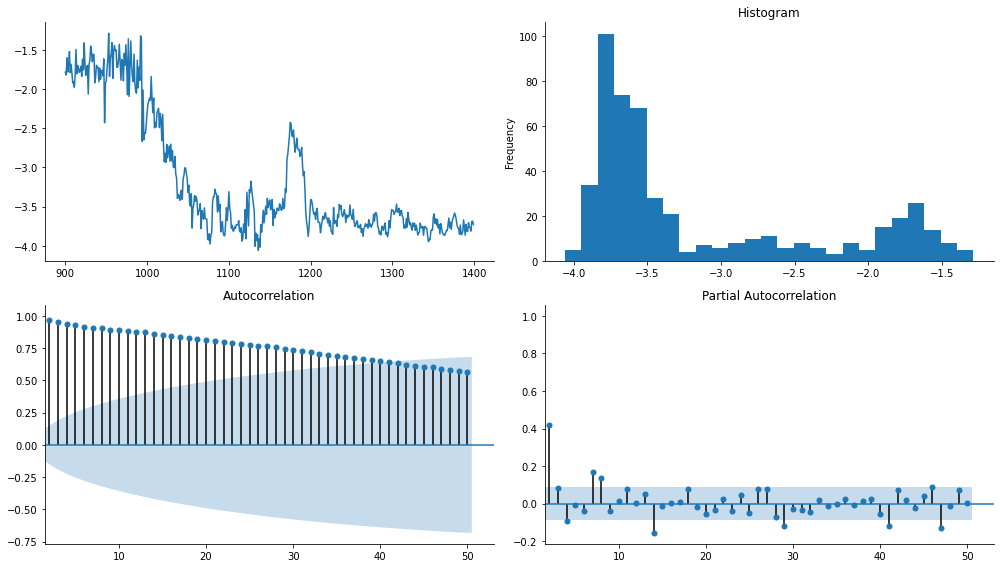

In [5]:
import statsmodels.api as sm
import seaborn as sns

def tsplot(y, lags=None, figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

tsplot(df.iloc[900:1400,30], lags=50);

To remove the non-stationary element of the variable we start differentiating the variable. This will be done until the adfuller test is positive. 

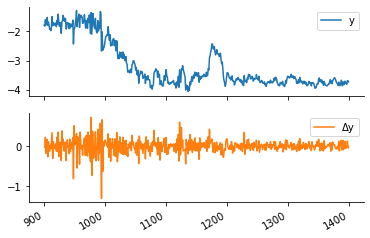

In [6]:
y = df.iloc[900:1400,30]
da= y.to_frame(name='y').assign(Δy=lambda x: x.y.diff())
da.plot(subplots=True)
sns.despine()

In [7]:
adf_test = adfuller(da["Δy"].dropna())

print ("ADF = " + str(adf_test[0]))
print ("p-value = " +str(adf_test[1]))

ADF = -11.74733145627084
p-value = 1.232539723451933e-21


To revert back to the original data we use the numpy cumsum function.

In [8]:
x, x_diff = da['y'].iloc[0], da['Δy'].iloc[1:]
da['y_back'] = np.r_[x, x_diff].cumsum()
da

,y,Δy,y_back
900,-1.784442,NaN,-1.784442
901,-1.817916,-0.033474,-1.817916
902,-1.599046,0.218871,-1.599046
903,-1.780861,-0.181815,-1.780861
904,-1.686034,0.094828,-1.686034
...,...,...,...
1395,-3.769323,-0.009247,-3.769323
1396,-3.813496,-0.044173,-3.813496
1397,-3.689416,0.124081,-3.689416
1398,-3.685638,0.003777,-3.685638


Plotting the stationary signal we can see that in the histogram the data has centered around 0 and Autocorrelation and Partial Autocorrelation are 0. 

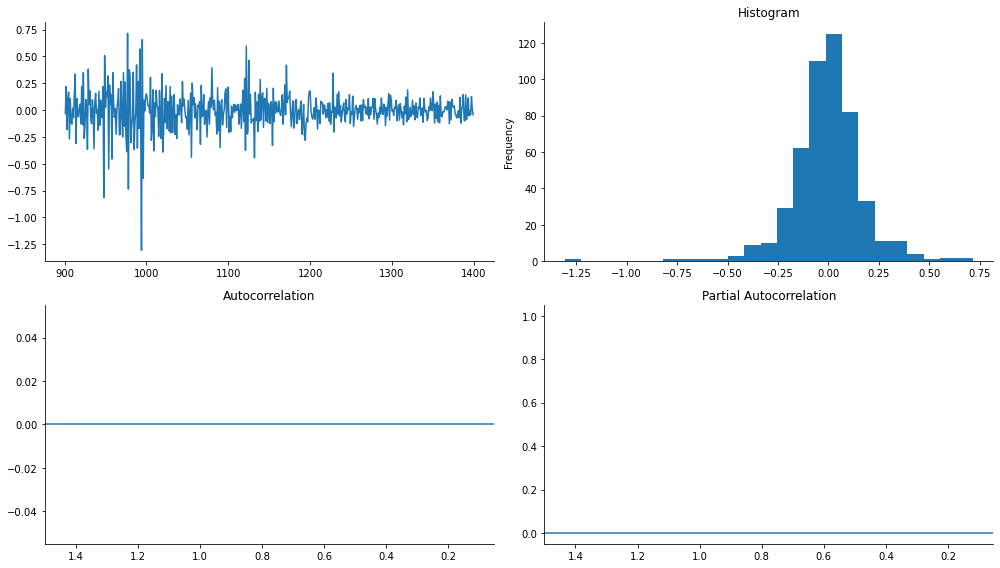

In [9]:
tsplot(da["Δy"], lags=50);